# Estimating the Date of COVID-19 Changes

https://nbviewer.jupyter.org/github/jramkiss/jramkiss.github.io/blob/master/_posts/notebooks/covid19-changes.ipynb 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

from scipy import stats
import statsmodels.api as sm
import pylab

# from google.colab import files
# from io import StringIO
# uploaded = files.upload()

url = 'https://raw.githubusercontent.com/assemzh/ProbProg-COVID-19/master/full_grouped.csv'
data = pd.read_csv(url)

data.Date = pd.to_datetime(data.Date)

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Create country


In [8]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country (country, end_date, state = False) : 
    if state :
        df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered"]]
    else : 
        df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
    df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

     # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
    df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

    # convert date string to datetime
    std_dateparser = lambda x: str(x)[5:10]
    df.date = pd.to_datetime(df.date)
    df['date_only'] = df.date.apply(std_dateparser)
    df = df.sort_values(by = "date")
    df = df[df.date <= end_date]


    # make new confirmed cases every day:
    cases_shifted = np.array([0] + list(df.confirmed[:-1]))
    daily_confirmed = np.array(df.confirmed) - cases_shifted
    df["daily_confirmed"] = daily_confirmed 

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
    ax = [ax]
    sns.lineplot(x = df.date, 
                 y = df.daily_confirmed, 
                 ax = ax[0])

    ax[0].set(ylabel='Daily Confirmed Cases')

    ax[0].axvline(pd.to_datetime('2020-03-21'), 
              linestyle = '--', linewidth = 1.5,
              label = "Policy start: Mar 21, 2020" ,
              color = "red") 

    
    ax[0].xaxis.get_label().set_fontsize(16)
    ax[0].yaxis.get_label().set_fontsize(16)
    ax[0].title.set_fontsize(20)
    ax[0].tick_params(labelsize=16)
    myFmt = mdates.DateFormatter('%b %-d')
    ax[0].xaxis.set_major_formatter(myFmt)

    ax[0].set(ylabel='Daily Confirmed Cases', xlabel='');
    ax[0].legend(loc = "bottom right", fontsize=12.8)
    ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every month

    sns.set_style("ticks")
    plt.tight_layout()
    sns.despine()
    plt.savefig('/content/sample_data/aus_daily.pdf')
    print(df.tail())
    return df


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

       country       date  confirmed  ...  recovered  date_only daily_confirmed
126  Australia 2020-05-27       7150  ...       6579      05-27              11
127  Australia 2020-05-28       7165  ...       6576      05-28              15
128  Australia 2020-05-29       7184  ...       6605      05-29              19
129  Australia 2020-05-30       7192  ...       6614      05-30               8
130  Australia 2020-05-31       7202  ...       6618      05-31              10

[5 rows x 7 columns]


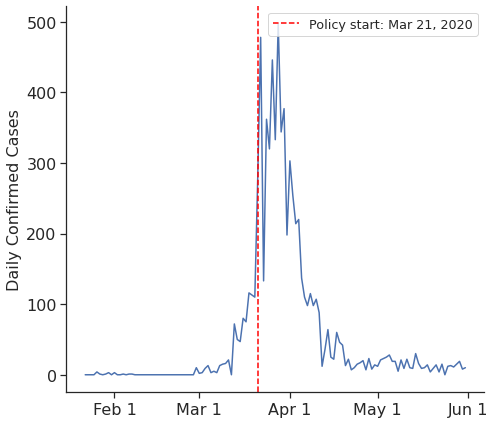

In [9]:
cad = create_country("Australia", end_date = "2020-05-31")

In [10]:
cad_start = "2020-03-01" # 13 confirmed cases
cad = cad[cad.date >= cad_start].reset_index(drop = True)
cad["days_since_start"] = np.arange(cad.shape[0]) + 1

In [11]:
cad.shape
cad_tmp = cad[cad.date < "2020-05-01"]
cad_tmp.shape

(61, 8)

## Data for Regression

In [12]:
# variable for data to easily swap it out:
country_ = "Australia (Before May 1st)"
reg_data = cad_tmp.copy()

In [13]:
reg_data.head()

,country,date,confirmed,deaths,recovered,date_only,daily_confirmed,days_since_start
0,Australia,2020-03-01,27,1,11,03-01,2,1
1,Australia,2020-03-02,30,1,11,03-02,3,2
2,Australia,2020-03-03,39,1,11,03-03,9,3
3,Australia,2020-03-04,52,2,11,03-04,13,4
4,Australia,2020-03-05,55,2,21,03-05,3,5


## Change Point Estimation in Pyro

In [14]:
!pip install pyro-ppl
!pip install numpyro

     |████████████████████████████████| 634kB 16.8MB/s 
     |████████████████████████████████| 225kB 20.0MB/s 
     |████████████████████████████████| 593kB 47.3MB/s 
     |████████████████████████████████| 35.7MB 78kB/s 
  Created wheel for jax: filename=jax-0.2.10-cp37-none-any.whl size=679776 sha256=7d0fef4762e0db39ed221ac892a147049a5b63230b808d9e1d7f4399db61851c
  Stored in directory: /root/.cache/pip/wheels/44/ea/ac/3be3bc19ee3b62f6fe1561eb6df1199284bb6bab819c1befa4
Successfully built jax
  Found existing installation: jax 0.2.12
    Uninstalling jax-0.2.12:
      Successfully uninstalled jax-0.2.12
  Found existing installation: jaxlib 0.1.65+cuda110
    Uninstalling jaxlib-0.1.65+cuda110:
      Successfully uninstalled jaxlib-0.1.65+cuda110


In [15]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [16]:
# we should be able to have an empirical estimate for the mean of the prior for the 2nd regression bias term
# this will be something like b = log(max(daily_confirmed))

# might be able to have 1 regression model but change the data so that we have new terms for (tau < t) 
# like an interaction term

class COVID_change(PyroModule):
    def __init__(self, in_features, out_features, b1_mu, b2_mu):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear1.weight = PyroSample(dist.Normal(0.5, 0.25).expand([1, 1]).to_event(1))
        self.linear1.bias = PyroSample(dist.Normal(b1_mu, 1.))
        
        # could possibly have stronger priors for the 2nd regression line, because we wont have as much data
        self.linear2 = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear2.weight = PyroSample(dist.Normal(0., 0.25).expand([1, 1])) #.to_event(1))
        self.linear2.bias = PyroSample(dist.Normal(b2_mu, b2_mu/4))

    def forward(self, x, y=None):
        tau = pyro.sample("tau", dist.Beta(4, 3))
        sigma = pyro.sample("sigma", dist.Uniform(0., 3.))
        # fit lm's to data based on tau
        sep = int(np.ceil(tau.detach().numpy() * len(x)))
        mean1 = self.linear1(x[:sep]).squeeze(-1)
        mean2 = self.linear2(x[sep:]).squeeze(-1)
        mean = torch.cat((mean1, mean2))
        obs = pyro.sample("obs", dist.StudentT(2, mean, sigma), obs=y)
        return mean

In [17]:
tensor_data = torch.tensor(reg_data[["confirmed", "days_since_start", "daily_confirmed"]].values, dtype=torch.float)
x_data = tensor_data[:, 1].unsqueeze_(1)
y_data = np.log(tensor_data[:, 0])
y_data_daily = np.log(tensor_data[:, 2])
# prior hyper params
# take log of the average of the 1st quartile to get the prior mean for the bias of the 2nd regression line
q1 = np.quantile(y_data, q = 0.25)
bias_1_mean = np.mean(y_data.numpy()[y_data <= q1])
print("Prior mean for Bias 1: ", bias_1_mean)

# take log of the average of the 4th quartile to get the prior mean for the bias of the 2nd regression line
q4 = np.quantile(y_data, q = 0.75)
bias_2_mean = np.mean(y_data.numpy()[y_data >= q4])
print("Prior mean for Bias 2: ", bias_2_mean)

Prior mean for Bias 1:  4.5138054
Prior mean for Bias 2:  8.800875


## Approximate Inference with Stochastic Variational Inference

# HMC with NUTS

In [ ]:
model = COVID_change(1, 1, 
                     b1_mu = bias_1_mean,
                     b2_mu = bias_2_mean)
# need more than 400 samples/chain if we want to use a flat prior on b_2 and w_2
num_samples = 400 
# mcmc 
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 
            num_samples=num_samples,
            warmup_steps = 200,
            num_chains = 1)
mcmc.run(x_data, y_data)
samples = mcmc.get_samples()

Sample: 100%|██████████| 600/600 [24:27,  2.45s/it, step size=1.31e-04, acc. prob=0.936]


In [22]:
# Save the model:
import dill
# with open('aus.pkl', 'wb') as f:
# 	dill.dump(mcmc, f)
with open('aus.pkl', 'rb') as f:
	mcmc = dill.load(f)
 
samples = mcmc.get_samples()

In [23]:
# extract individual posteriors
weight_1_post = samples["linear1.weight"].detach().numpy()
weight_2_post = samples["linear2.weight"].detach().numpy()
bias_1_post = samples["linear1.bias"].detach().numpy()
bias_2_post = samples["linear2.bias"].detach().numpy()
tau_post = samples["tau"].detach().numpy()
sigma_post = samples["sigma"].detach().numpy()

# build likelihood distribution:
tau_days = list(map(int, np.ceil(tau_post * len(x_data))))
mean_ = torch.zeros(len(tau_days), len(x_data))
obs_ = torch.zeros(len(tau_days), len(x_data))
for i in range(len(tau_days)) : 
    mean_[i, :] = torch.cat((x_data[:tau_days[i]] * weight_1_post[i] + bias_1_post[i],
                          x_data[tau_days[i]:] * weight_2_post[i] + bias_2_post[i])).reshape(len(x_data))
    obs_[i, :] = dist.Normal(mean_[i, :], sigma_post[i]).sample()
samples["_RETURN"] = mean_
samples["obs"] = obs_
pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma
y_shift = np.exp(y["mean"]) - np.exp(torch.cat((y["mean"][0:1], y["mean"][:-1])))
print(y_shift)
predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_confirmed": y_data,
    "true_daily_confirmed": y_data_daily,
    "y_daily_mean": y_shift
})

w1_ = pred_summary["linear1.weight"]
w2_ = pred_summary["linear2.weight"]

b1_ = pred_summary["linear1.bias"]
b2_ = pred_summary["linear2.bias"]

tau_ = pred_summary["tau"]
sigma_ = pred_summary["sigma"]

ind = int(np.ceil(tau_["mean"] * len(x_data)))

tensor([   0.0000,    4.4640,    5.2986,    6.8328,    7.8025,    9.8307,
          11.8612,   13.4422,   16.9518,   21.2977,   25.7285,   30.4241,
          37.7013,   43.8305,   55.0542,   66.6997,   82.1629,   95.6561,
         117.4060,  145.2230,  175.4886,  211.9290,  252.8590,  310.6555,
         379.7236,  451.5439,  559.8037,  658.4072,  847.2842,  877.7178,
         175.0576, -171.3018,   37.2290,   74.0874,   53.8413,    3.1011,
          94.8687,   41.6509,   16.6680,   45.3633,   94.5469,   -3.4326,
          76.7153,   62.1982,   78.2866,   68.9971,   30.5205,   19.0586,
          94.0020,   30.3032,   79.4014,   12.0522,   31.2920,   95.9932,
          42.5098,   67.3188,   84.3203,   12.1406,   83.1426,   40.8364,
          60.2397])


## Model Diagnostics

- Residual plots: Should these be samples from the likelihood compared with the actual data? Or just the mean of the likelihood?
- $\hat{R}$: The factor that the scale of the current distribution will be reduced by if we were to run the simulations forever. As n tends to $\inf$, $\hat{R}$ tends to 1. So we want values close to 1.
- Mixing and Stationarity: I sampled 4 chains. Do I then take these chains, split them in half and plot them. If they converge to the same stationary distribution, does that mean the MCMC converged? What do I do with more sampled chains?

In [ ]:
mcmc.summary()
diag = mcmc.diagnostics()

## Posterior Plots

30
2020-03-31 00:00:00


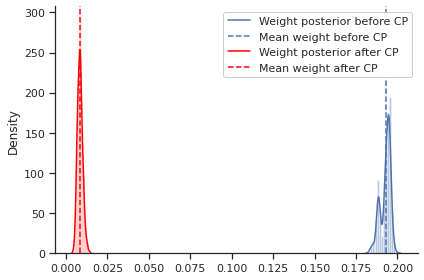

In [31]:
print(ind)
print(reg_data.date[ind])

sns.distplot(weight_1_post, 
             kde_kws = {"label": "Weight posterior before CP"}, 
            #  color = "blue",
             norm_hist = True,
             kde = True)
plt.axvline(x = w1_["mean"], linestyle = '--',label = "Mean weight before CP" ,)
              # color = "blue")

sns.distplot(weight_2_post, 
             kde_kws = {"label": "Weight posterior after CP"}, 
             color = "red",
             norm_hist = True,
             kde = True)
plt.axvline(x = w2_["mean"], linestyle = '--',label = "Mean weight after CP" ,
              color = "red")

legend = plt.legend(loc='upper right')
legend.get_frame().set_alpha(1)
sns.set_style("ticks")
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/aus_weights.pdf')

In [ ]:
print(w1_["mean"])
print(w2_["mean"])

tensor([[0.1928]])
tensor([[0.0085]])


In [ ]:
1- w2_['mean']/w1_['mean']

tensor([[0.9561]])

In [38]:
reg_data.date[40]

Timestamp('2020-04-10 00:00:00')

Date of change for Australia (Before May 1st): 2020-03-31
Index(['country', 'date', 'confirmed', 'deaths', 'recovered', 'date_only',
       'daily_confirmed', 'days_since_start'],
      dtype='object')


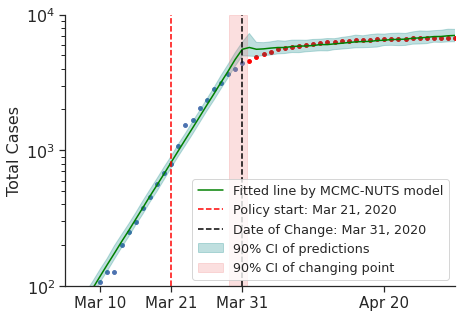

In [46]:
start_date_ = str(reg_data.date[0]).split(' ')[0]
change_date_ = str(reg_data.date[ind]).split(' ')[0]
print("Date of change for {}: {}".format(country_, change_date_))
import seaborn as sns

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax = [ax]
# log regression model
ax[0].scatter(y = np.exp(y_data[:ind]), x = x_data[:ind], s = 15);
ax[0].scatter(y = np.exp(y_data[ind:]), x = x_data[ind:], s = 15, color = "red");

ax[0].plot(predictions["days_since_start"],
           np.exp(predictions["y_mean"]), 
           color = "green",
           label = "Fitted line by MCMC-NUTS model") 
ax[0].axvline(20, 
              linestyle = '--', linewidth = 1.5,
              label = "Policy start: Mar 21, 2020" ,
              color = "red")

ax[0].axvline(ind, 
              linestyle = '--', linewidth = 1.5,
              label = "Date of Change: Mar 31, 2020",
              color = "black")

ax[0].fill_between(predictions["days_since_start"], 
                   np.exp(predictions["y_perc_5"]), 
                   np.exp(predictions["y_perc_95"]), 
                   alpha = 0.25,
                   label = "90% CI of predictions",
                   color = "teal");
ax[0].fill_betweenx([0, 1], 
                    tau_["5%"] * len(x_data), 
                    tau_["95%"] * len(x_data), 
                    alpha = 0.25,
                    label = "90% CI of changing point",
                    color = "lightcoral",
                    transform=ax[0].get_xaxis_transform());
ax[0].set(ylabel = "Total Cases",)

ax[0].legend(loc = "lower right", fontsize=12.8)
ax[0].set_ylim([100,10000])
ax[0].set_xlim([5,60])
ax[0].xaxis.get_label().set_fontsize(16)
ax[0].yaxis.get_label().set_fontsize(16)
ax[0].title.set_fontsize(20)
ax[0].tick_params(labelsize=16)

plt.xticks(ticks=[10,20,30,50], labels=["Mar 10",
                                             "Mar 21",
                                             "Mar 31",
                                            "Apr 20"], fontsize=15)
ax[0].set_yscale('log')
plt.setp(ax[0].get_xticklabels(), rotation=0, horizontalalignment='center')
print(reg_data.columns)
myFmt = mdates.DateFormatter('%m-%d')
sns.set_style("ticks")
sns.despine()
plt.savefig('/content/sample_data/aus_cp.pdf')


**Date of change for Australia (Before May 1st): 2020-03-31**

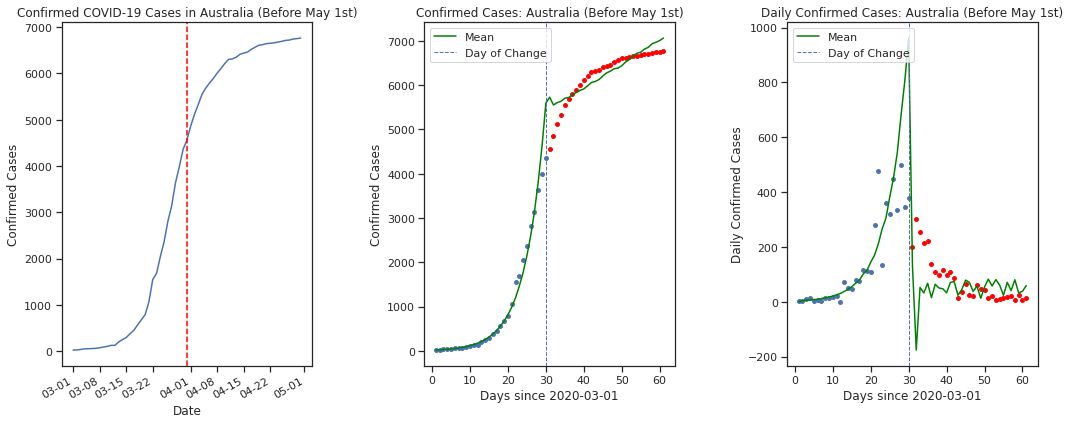

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 6))

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
             y="confirmed", 
             data= reg_data,
             ax = ax[0]
            ).set_title("Confirmed COVID-19 Cases in %s" % country_)
ax[0].axvline(reg_data.date[ind], color="red", linestyle="--")
ax[1].scatter(y = reg_data.confirmed[:ind], x = x_data[:ind], s = 15);
ax[1].scatter(y = reg_data.confirmed[ind:], x = x_data[ind:], s = 15, color = "red");

ax[1].plot(predictions["days_since_start"],
           np.exp(predictions["y_mean"]), 
           color = "green",
           label = "Mean") 
ax[1].axvline(ind, linestyle = '--', 
              linewidth = 1,
              label = "Day of Change")
ax[1].legend(loc = "upper left")
ax[1].set(ylabel = "Confirmed Cases", 
          xlabel = "Days since %s" % start_date_,
          title = "Confirmed Cases: %s" % country_);


ax[2].scatter(y = reg_data.daily_confirmed[:ind], x = x_data[:ind], s = 15);
ax[2].scatter(y = reg_data.daily_confirmed[ind:], x = x_data[ind:], s = 15, color = "red");

ax[2].plot(predictions["days_since_start"],
           predictions["y_daily_mean"], 
           color = "green",
           label = "Mean") 

ax[2].axvline(ind, linestyle = '--', 
              linewidth = 1,
              label = "Day of Change")
ax[2].legend(loc = "upper left")
ax[2].set(ylabel = "Daily Confirmed Cases", 
          xlabel = "Days since %s" % start_date_,
          title = "Daily Confirmed Cases: %s" % country_);
printmd("**Date of change for {}: {}**".format(country_, change_date_));

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')
ax[0].xaxis.set_major_formatter(myFmt)

# ax[0].set_xticklabels(reg_data.date, rotation = 45,  fontsize="10", va="center")
plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment='right')
ax[0].set(ylabel='Confirmed Cases', xlabel='Date');

plt.tight_layout()
plt.savefig('/content/sample_data/sing_mean.pdf')